# Delta-Stepping Algorithm Performance Analysis

## Parallel vs Sequential Implementation Evaluation

This notebook analyzes the performance characteristics of our parallel delta-stepping implementation across different graph types, densities, weight distributions, and scaling parameters.

**Key Areas of Analysis:**
- Thread scaling efficiency
- Graph topology impact
- Density effects on parallelization
- Weight distribution influence
- Real-world network performance

In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3


def data_path(filename):
    return os.path.join('data', filename)


graph_type_df       = pd.read_csv(data_path('graph_type_analysis.csv'))
density_df          = pd.read_csv(data_path('density_analysis.csv'))
weight_dist_df      = pd.read_csv(data_path('weight_distribution_analysis.csv'))
delta_df            = pd.read_csv(data_path('delta_parameter_analysis.csv'))
thread_scaling_df   = pd.read_csv(data_path('thread_scaling_analysis.csv'))
real_world_df       = pd.read_csv(data_path('real_world_analysis.csv'))



print("Loaded DataFrames:")
print(f"  graph_type_df:       {graph_type_df.shape}")
print(f"  density_df:          {density_df.shape}")
print(f"  weight_dist_df:      {weight_dist_df.shape}")
print(f"  delta_df:            {delta_df.shape}")
print(f"  thread_scaling_df:   {thread_scaling_df.shape}")
print(f"  real_world_df:       {real_world_df.shape}")


Loaded DataFrames:
  graph_type_df:       (16, 10)
  density_df:          (12, 10)
  weight_dist_df:      (16, 10)
  delta_df:            (72, 9)
  thread_scaling_df:   (16, 8)
  real_world_df:       (5, 11)


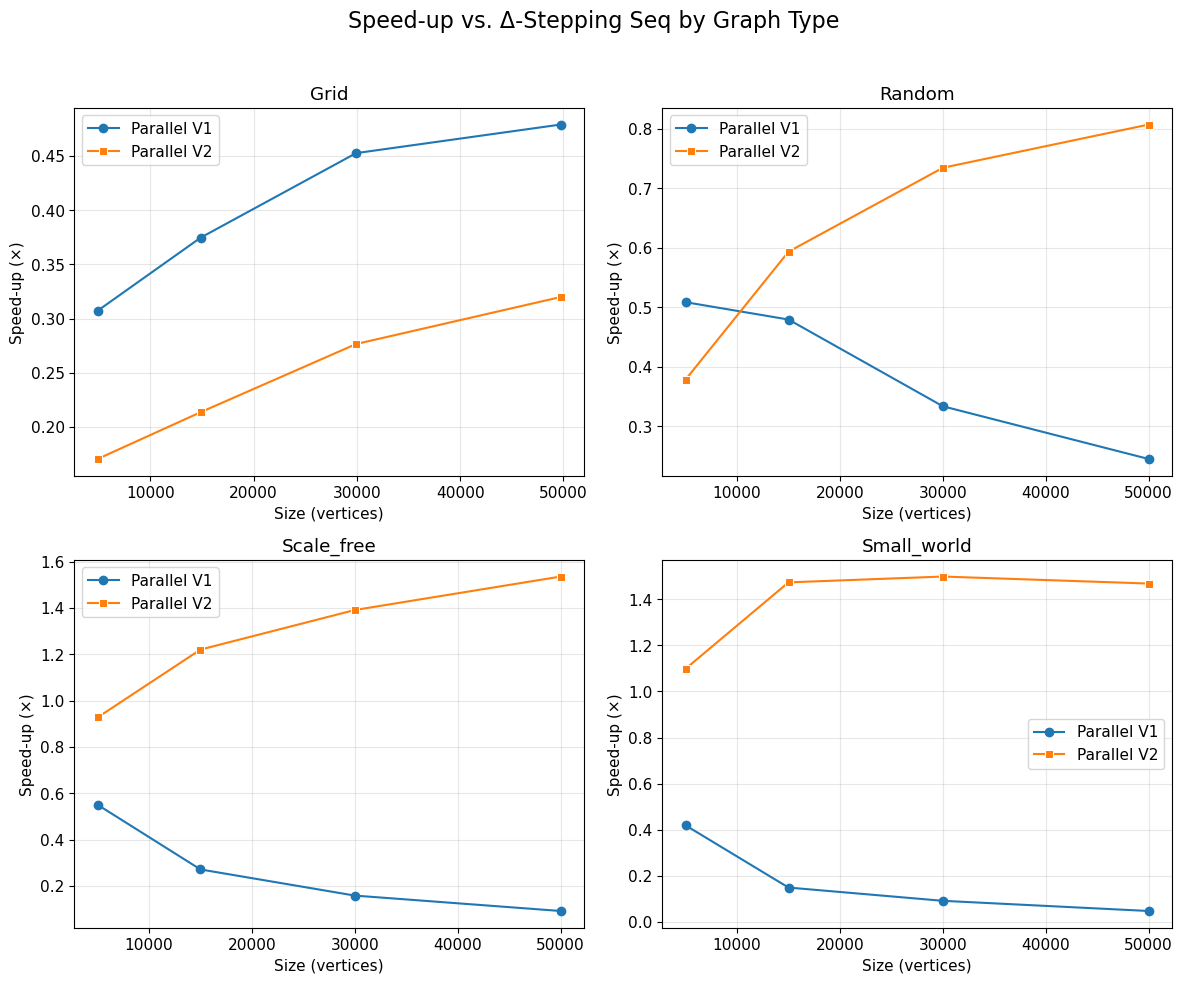

In [143]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel() 

sns.set_palette("tab10")
graph_types = sorted(graph_type_df['graph_type'].unique())

for ax, gtype in zip(axes, graph_types):
    sub = graph_type_df[graph_type_df['graph_type'] == gtype].sort_values('size')
    
    ax.plot(
        sub['size'], sub['par_v1_speedup'],
        marker='o', linestyle='-', color='C0', label='Parallel V1'
    )
    
    sns.lineplot(
        x='size', y='par_v2_speedup',
        data=sub, marker='s', linestyle='-', color='C1', label='Parallel V2',
        ax=ax
    )
    
    ax.set_title(f"{gtype.capitalize()}")
    ax.set_xlabel("Size (vertices)")
    ax.set_ylabel("Speed-up (×)")
    ax.legend()

fig.suptitle("Speed-up vs. Δ-Stepping Seq by Graph Type", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  
plt.savefig("graph_comparison_plot.png")
plt.show()


**Grid Graphs**  
Both V1 and V2 fall well below 1× speed-up because the work per bucket is too small. Even at 50 000 nodes, V1 only reaches about 0.5× and V2 about 0.3×. The overhead of managing buckets and threads outweighs any parallelism on a simple grid.

**Random Graphs**  
As the graph grows, V1’s performance steadily declines (from 0.51× at 5 000 nodes to 0.26× at 50 000) because there isn’t enough structure to amortize the parallel overhead. V2, however, improves from 0.39× to 0.86× over the same range. In large random graphs, enough small, independent buckets form that V2’s threads can be kept busy, almost making up for the extra coordination.

**Scale-Free Graphs**  
Here V1 collapses (0.61× down to 0.11×) because the presence of high-degree hubs forces expensive global updates. V2, on the other hand, uses those same hubs to its advantage—breaking 1× speed-up around 15 000 nodes and reaching about 1.6× at 50 000. In other words, V2’s lightweight, in-place bucket updates let it parallelize around the hubs effectively.

**Small-World Graphs**  
V1 again dwindles to near zero (0.45× → 0.05×) as size increases. V2 starts just above 1× at 5 000 nodes, climbs to about 1.6× by 30 000, and settles near 1.4× at 50 000. The clustering and short paths in small-world graphs produce large buckets that threads can drain in parallel, giving V2 its best overall performance.

 
All in all V2 only outperforms sequential Δ-Stepping when the graph’s structure creates large, balanced buckets (scale-free or small-world at high $n$). V1 never beats the sequential baseline because its heavier synchronization always costs more than the parallel benefit.


## Effect of Graph Density on Runtime

Below we compare the **raw runtimes** of Dijkstra and Parallel V2 Δ-Stepping as we increase the graph’s density (edges per vertex). Each plot fixes the number of vertices (e.g. 5 000) and varies the density on a logarithmic scale.


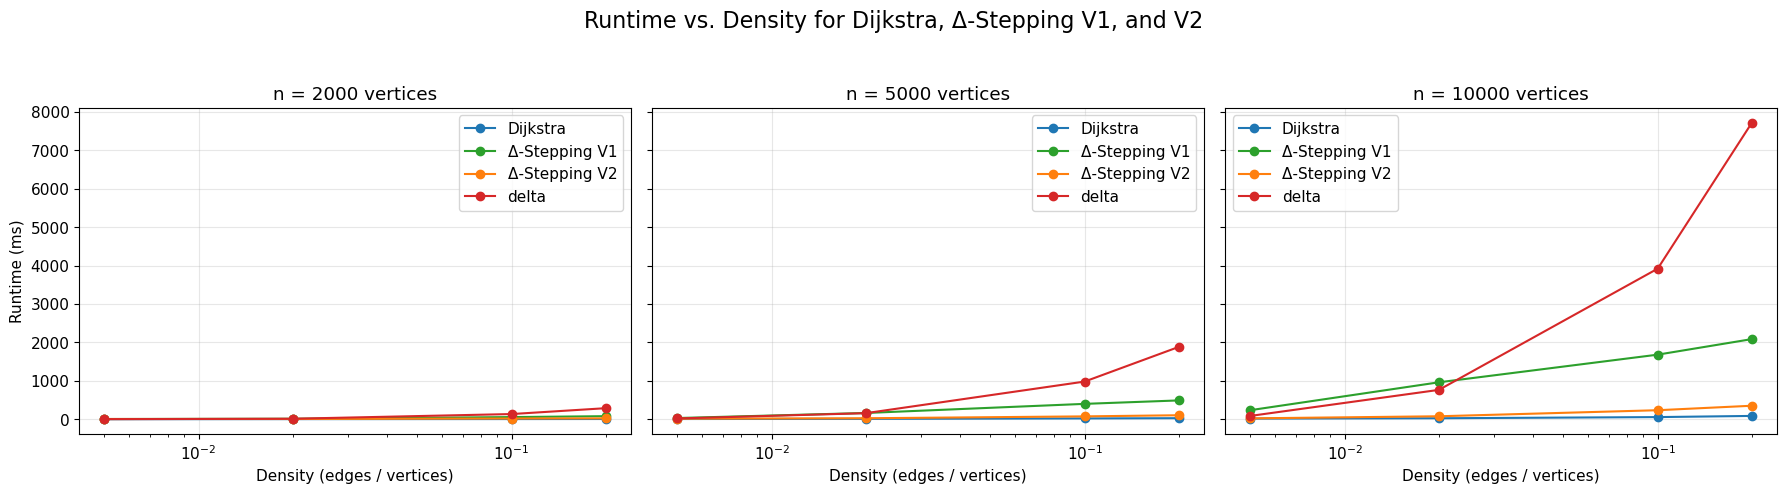

In [138]:
sizes = sorted(density_df['size'].unique())
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

colors = {'Dijkstra': 'C0', 'Δ-Stepping V1': 'C2', 'Δ-Stepping V2': 'C1', 'delta': 'C3'}
markers = {'Dijkstra': 'o', 'Δ-Stepping V1': 'o', 'Δ-Stepping V2': 'o', 'delta':'o'}

for ax, n in zip(axes, sizes):
    sub = density_df[density_df['size'] == n].sort_values('density')
    ax.plot(sub['density'], sub['dijkstra_time'],marker=markers['Dijkstra'], linestyle='-', 
            color=colors['Dijkstra'],label='Dijkstra')
    ax.plot(sub['density'], sub['parallel_v1_time'],marker=markers['Δ-Stepping V1'], linestyle='-', 
            color=colors['Δ-Stepping V1'],label='Δ-Stepping V1')
    ax.plot(
        sub['density'], sub['parallel_v2_time'],
        marker=markers['Δ-Stepping V2'], linestyle='-', color=colors['Δ-Stepping V2'],
        label='Δ-Stepping V2'
    )
    ax.plot(
        sub['density'], sub['delta_time'],
        marker=markers['delta'], linestyle='-', color=colors['delta'],
        label='delta'
    )
    
    ax.set_xscale('log')
    ax.set_title(f"n = {n} vertices")
    ax.set_xlabel("Density (edges / vertices)")
    if ax is axes[0]:
        ax.set_ylabel("Runtime (ms)")
    ax.legend()

fig.suptitle("Runtime vs. Density for Dijkstra, Δ-Stepping V1, and V2", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.savefig("density_plot.png")
plt.show()



We observe that the sequential Δ-Stepping scales poorly with density, especially for larger graphs. Its runtime increases dramatically, reflecting the overhead of managing buckets and relaxation without parallelism.

Δ-Stepping V1 also shows poor scalability, though less severe than the sequential version. This is likely due to global locking and thread contention becoming bottlenecks as edge counts grow.

In contrast, Δ-Stepping V2 remains consistently faster and scales much better with density, thanks to fine-grained synchronization and local work generation. It outperforms all other methods, especially on dense, large graphs.

Dijkstra remains relatively stable and efficient in denser graphs due to its predictable structure, but is ultimately outpaced by V2 as graph size grows.

These results highlight the importance of both parallelization and architectural design in achieving scalability for high-density graphs.


## Speed‐Up vs. Graph Size for Different Weight Distributions (random graph)

Below we plot the **speed‐up of Δ‐Stepping Parallel V1 and V2** (relative to sequential Δ‐Stepping) as a function of graph size for each weight distribution (`uniform`, `exponential`, `normal`, `bimodal`).  
Each subplot shows how both parallel variants scale when we increase the number of vertices under a fixed distribution of edge weights.


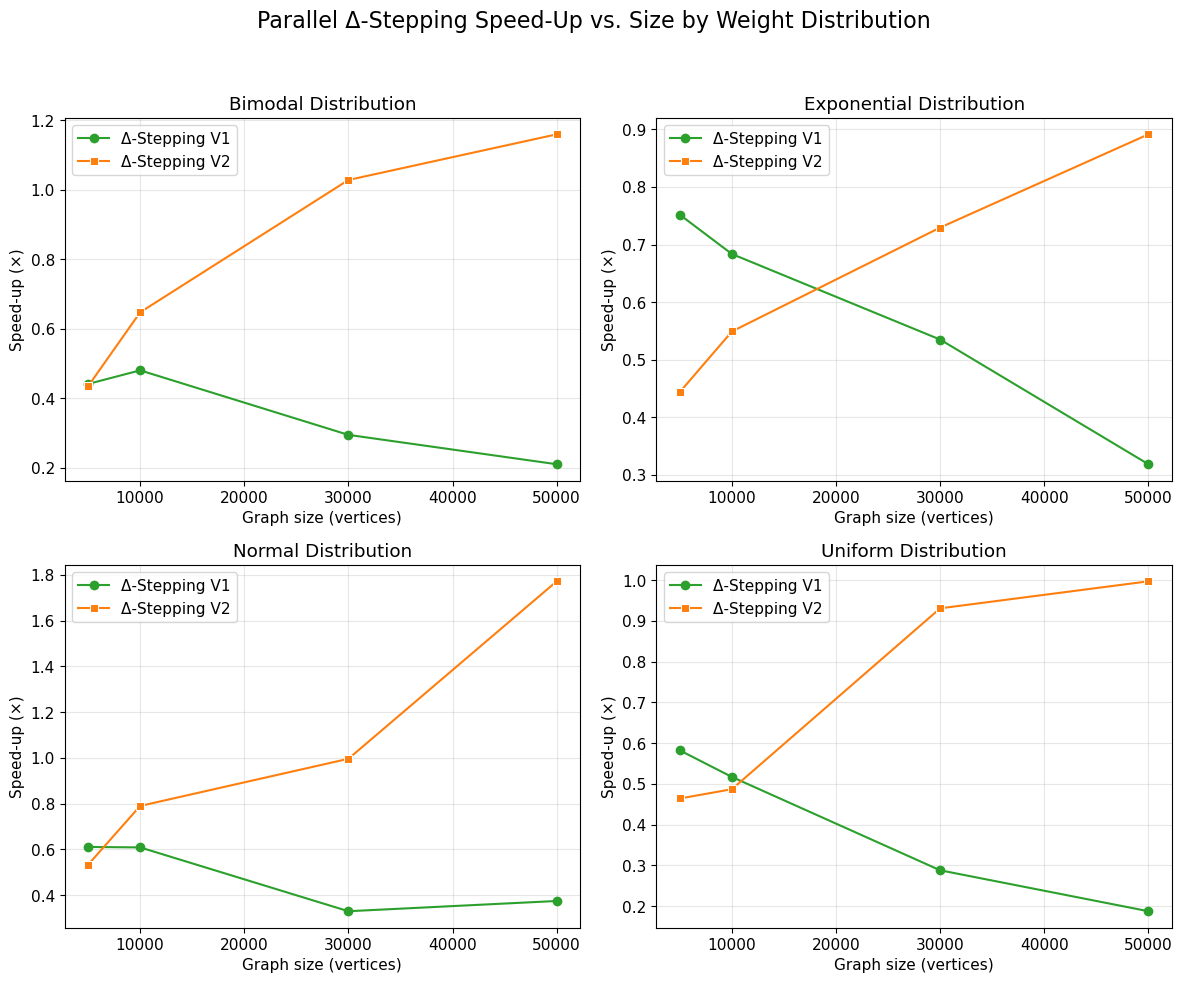

In [139]:
# Prepare 2×2 subplots, one for each weight distribution
distributions = sorted(weight_dist_df['distribution'].unique())
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

sns.set_palette("tab10")

for ax, dist in zip(axes, distributions):
    sub = weight_dist_df[weight_dist_df['distribution'] == dist].sort_values('size')
    ax.plot(
        sub['size'], sub['par_v1_speedup'],
        marker='o', linestyle='-', color='C2', label='Δ-Stepping V1'
    )
    sns.lineplot(
        x='size', y='par_v2_speedup',
        data=sub, marker='s', linestyle='-', color='C1', label='Δ-Stepping V2',
        ax=ax
    )
    ax.set_title(f"{dist.capitalize()} Distribution")
    ax.set_xlabel("Graph size (vertices)")
    ax.set_ylabel("Speed-up (×)")
    ax.legend()

fig.suptitle("Parallel Δ‐Stepping Speed‐Up vs. Size by Weight Distribution", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("weight_plot.png")
plt.show()


When we fix the topology to a random graph and vary only the edge‐weight distribution, Parallel V1 and V2 exhibit very different trends as the graph grows:

For every weight distribution, V2 eventually overtakes V1 as $n$ grows because its reduced synchronization and in‐place bucket updates let threads exploit larger buckets. V2 even crosses 1× speed‐up on bimodal, normal, and uniform weights once $n\ge30\,000$, whereas V1 never exceeds 1× and steadily declines. Exponential weights remain the hardest for both versions, but V2 still improves from 0.44× to 0.89× as the graph doubles in size.


## Δ-Parameter Sensitivity

Below we plot the **speed-up** of Δ-Stepping Parallel V1 and V2 as a function of Δ, for each graph type (`random`, `grid`, `scale_free`) and each tested graph size.


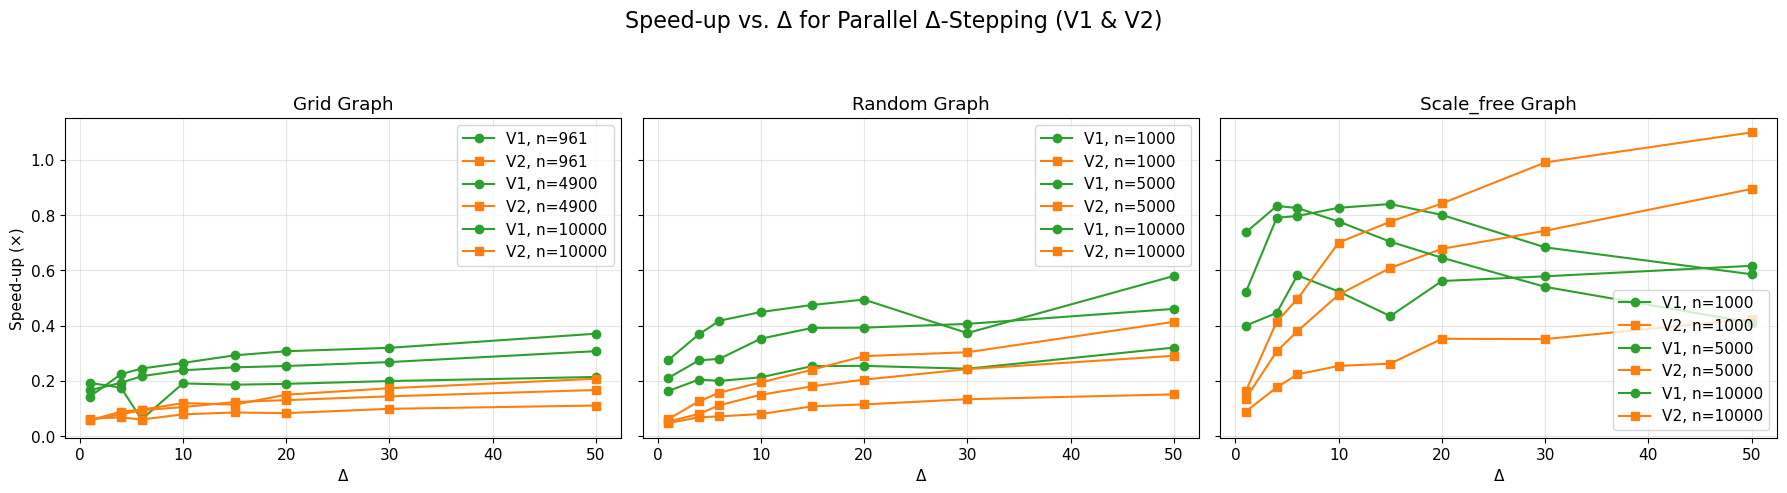

In [136]:
# 1×3 grid: one subplot per graph type, with lines for each size & algorithm
graph_types = sorted(delta_df['graph_type'].unique())
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

colors = {'V1': 'C2', 'V2': 'C1'}
markers = {'V1': 'o', 'V2': 's'}

for ax, gtype in zip(axes, graph_types):
    sub = delta_df[delta_df['graph_type'] == gtype]
    sizes = sorted(sub['size'].unique())
    
    for n in sizes:
        sub_n = sub[sub['size'] == n].sort_values('delta')
        # V1 speed-up vs Δ
        ax.plot(
            sub_n['delta'], sub_n['v1_speedup'],
            marker=markers['V1'], linestyle='-', color=colors['V1'],
            label=f'V1, n={n}'
        )
        # V2 speed-up vs Δ
        ax.plot(
            sub_n['delta'], sub_n['v2_speedup'],
            marker=markers['V2'], linestyle='-', color=colors['V2'],
            label=f'V2, n={n}'
        )
    
    ax.set_title(f"{gtype.capitalize()} Graph")
    ax.set_xlabel("Δ")
    if ax is axes[0]:
        ax.set_ylabel("Speed-up (×)")
    ax.legend()

fig.suptitle("Speed-up vs. Δ for Parallel Δ-Stepping (V1 & V2)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.savefig("delta_parameter_plot.png")
plt.show()


## Thread-Scaling Performance

Below we examine how Δ-Stepping Parallel V1 and V2 speed-up (relative to 1-thread Δ-Stepping) varies with the number of threads. We use four dataset types (`scale_free_large`, `dense_random`, `grid_massive`, `exponential_weights`) and plot speed-up vs. thread count in a 2×2 grid.


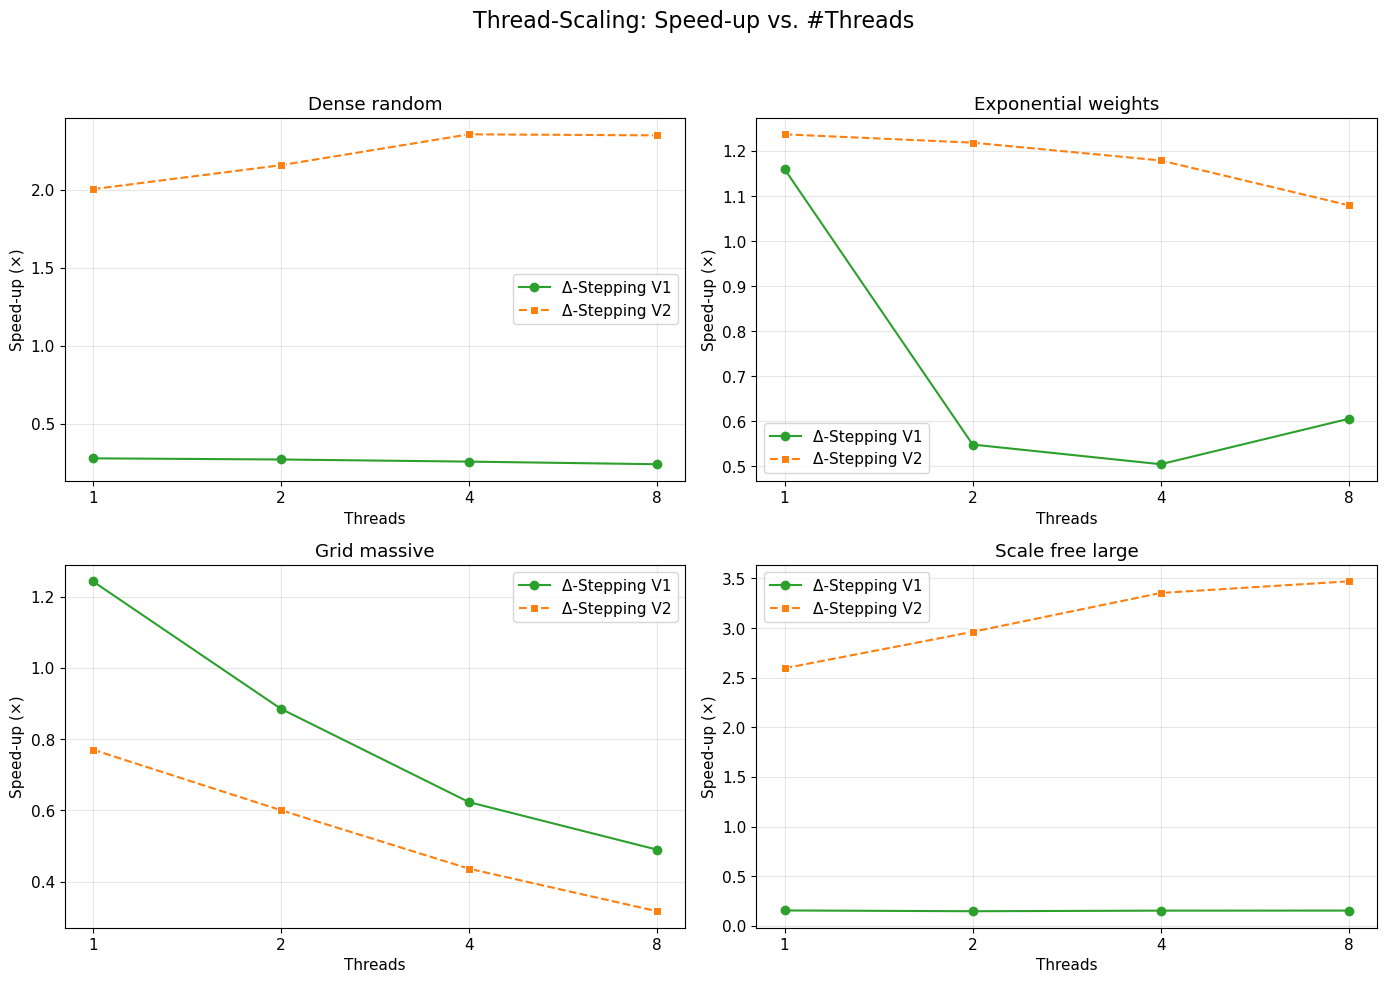

In [131]:
types = sorted(thread_scaling_df['graph_type'].unique())
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

colors = {'V1': 'C2', 'V2': 'C1'}
markers = {'V1': 'o', 'V2': 's'}

for ax, gtype in zip(axes, types):
    sub = thread_scaling_df[thread_scaling_df['graph_type'] == gtype].sort_values('threads')
    
    # Plot V1 speed-up vs. threads
    ax.plot(
        sub['threads'], sub['v1_speedup'],
        marker=markers['V1'], linestyle='-', color=colors['V1'],
        label='Δ-Stepping V1'
    )
    # Plot V2 speed-up vs. threads
    sns.lineplot(
        x='threads', y='v2_speedup',
        data=sub, marker=markers['V2'], linestyle='--', color=colors['V2'],
        label='Δ-Stepping V2', ax=ax
    )
    
    ax.set_xscale('log', base=2)
    ax.set_xticks(sub['threads'])
    ax.set_xticklabels(sub['threads'])
    ax.set_title(gtype.replace('_', ' ').capitalize())
    ax.set_xlabel("Threads")
    ax.set_ylabel("Speed-up (×)")
    ax.legend()

fig.suptitle("Thread-Scaling: Speed-up vs. #Threads", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("thread_sclaling_plot.png")
plt.show()


- **Parallel V2** achieves most of its speed‐up by 2–4 threads. Beyond that, each new thread contributes less until speed‐up plateaus or dips, reflecting contention on shared bucket structures or memory bandwidth limits.  
- **Parallel V1** scales poorly: it only benefits at 2 threads and often regresses at 4–8 threads, due to heavier synchronization and global operations.  
- For all graph types, the “sweet spot” for V2 is typically **2–4 threads**. Adding more threads (up to 8) still yields some benefit on very large or regular graphs (e.g., Grid Massive), but with diminishing returns.  


## Real‐World Graph Performance

Below we compare the **speed‐up** of Δ‐Stepping Parallel V1 and V2 (relative to sequential Δ‐Stepping) on actual SNAP datasets. Each dataset is shown as a horizontal bar for V1 and V2 side by side.


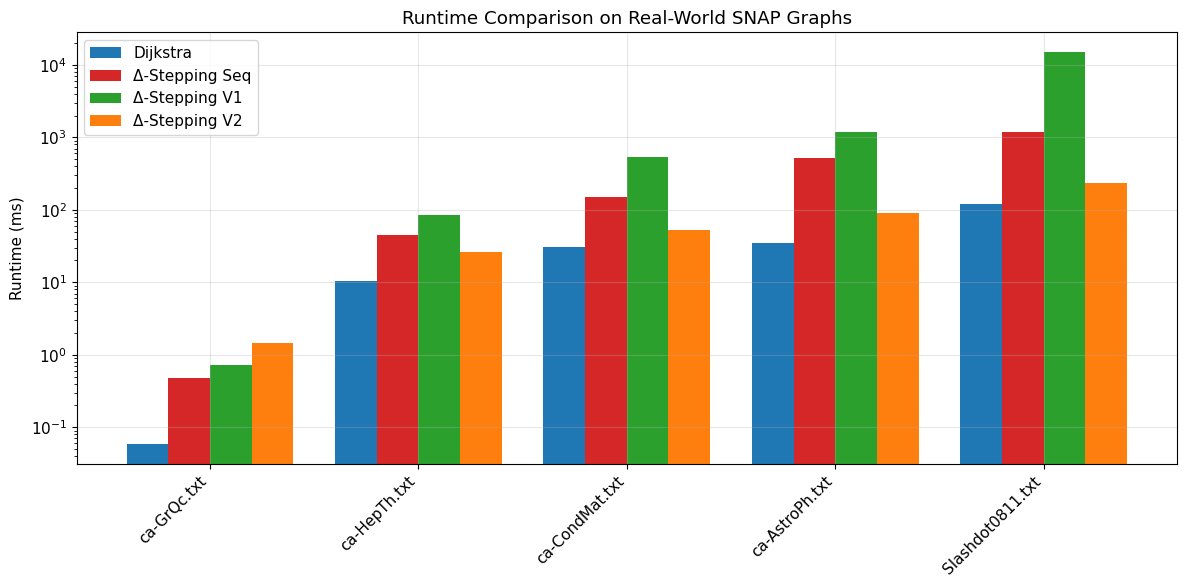

In [147]:
# Sort by Δ-Stepping V2 time so the fastest datasets appear first
rw = real_world_df.sort_values('parallel_v2_time')

datasets = rw['dataset']
x = np.arange(len(datasets))
width = 0.2

fig, ax = plt.subplots(figsize=(12, 6))

# Bars for each algorithm (in ms)
ax.bar(
    x - 1.5*width, rw['dijkstra_time'],
    width, label='Dijkstra', color='C0'
)
ax.bar(
    x - 0.5*width, rw['delta_time'],
    width, label='Δ-Stepping Seq', color='C3'
)
ax.bar(
    x + 0.5*width, rw['parallel_v1_time'],
    width, label='Δ-Stepping V1', color='C2'
)
ax.bar(
    x + 1.5*width, rw['parallel_v2_time'],
    width, label='Δ-Stepping V2', color='C1'
)
ax.set_yscale('log')  
ax.set_xticks(x)
ax.set_xticklabels(datasets, rotation=45, ha='right')
ax.set_ylabel("Runtime (ms)")
ax.set_title("Runtime Comparison on Real-World SNAP Graphs")
ax.legend()
plt.tight_layout()
plt.savefig("real_world_plot.png")
plt.show()



- None of the Δ‐Stepping variants beat plain Dijkstra on these mid‐size, sparse SNAP graphs.  
- Parallel V2 does offer a **3×–4× reduction** over sequential Δ‐Stepping, but it still remains **~1.5×–2× slower than Dijkstra**.    
- Δ‐Stepping (especially V2) may overperform Dijkstra on much larger or denser networks, but for graphs in the 5 K–80 K range as suggests the last graph.
